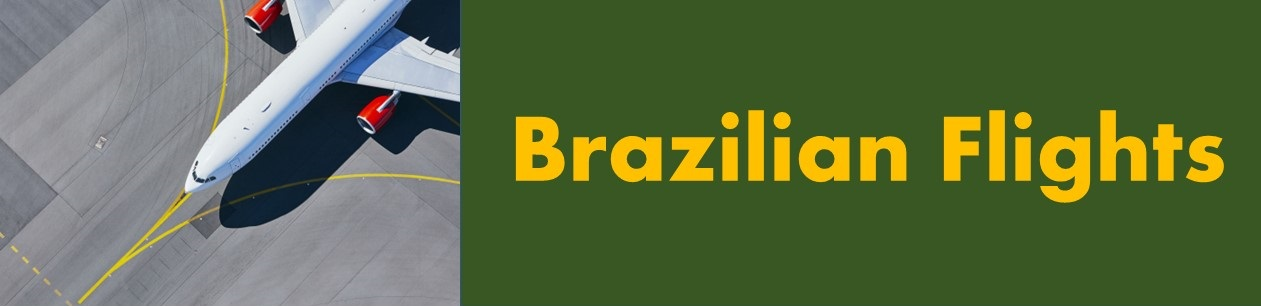

# Preparamos el entorno 🏡

Para el proyecto haremos uso de Dask y XGBoost para demostrar su aplicación (También se hizo otro ejercicio smiliar pero para PySpark)
La fuente de los datos viene de IEEE Data Port
Específicamente: Brazilian Flights Dataset / Autor: Claudio Teixeira CEFET-RJ
Extracción al 1ro de septiembre, 2022 (actualizado a esa fecha hasta 2020)
https://www.rd.com/list/what-can-a-billion-dollars-buy-you/

In [ ]:
#-- Primero, todas las instalaciones requeridas para este ejercicio
!python -m pip install "dask[complete]"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Columnas del Dataset Brazilian Flights ✈

1. flight_id - ANAC flight identifier;
2. airline_icao - ICAO acronym of the airline. Ex: GLO, TAM, ONE;
3. airline_name - Full name of the airline;
4. lynetype_code - (N) National, (I) International, (R) Regional, (H) Sub-regional, (E) Special, (C) Freight / Cargo, (G) International Freight / Cargo and (L) Postal Network;
5. origin_icao - ICAO code of the flight origin airport;
6. origin_country - ISO Country Name where the origin airport is located;
7. origin_name - Full name of the airport of origin of the flight;
8. expected_depart_date - Expected flight departure date in YYYYMMDD format where YYYY = year, MM = month and DD = day;
9. expected_depart_hour - Estimated flight departure hour in HH format where HH = full hour;
10. real_depart_date - Flight departure date in YYYYMMDD format where YYYY = year, MM = month and DD = day;
11. real_depart_hour - Flight departure in HH format where HH = full hour;
12. expected_duration - Difference in minutes between expected departure and arrival datetime;
13. departure_delay - Difference in minutes between expected and real departure datetime;
14. depart_temperature - Temperature in degrees Celsius at the airport of origin, at the time of flight departure;
15. depart_dew_point - Dew point, in degrees Celsius at the airport of origin, at the time of flight departure;
16. depart_humidity - Percentage of relative humidity in the airport of origin;
17. depart_pressure - Atmospheric pressure, in mbar, at the airport of origin;
18. depart_visibility - Visibility, in miles, at the airport of origin;
19. depart_wind_speed - Wind speed, in knots, at the airport of origin;
20. depart_wind_direction - Wind direction, based on Wind Rose, at the airport of origin;
21. destination_icao - ICAO code of the destination airport of the flight;
22. destination_name - Full name of the airport of destination of the flight;
23. destination_country - ISO country name where the destination airport is located;
24. expected_arrival_date - Estimated date and time of flight arrival in YYYYMMDD format where YYYY = year, MM = month and DD = day;
25. expected_arrival_hour - Estimated flight arrival hour in HH format where HH = full hour;
26. real_arrival_date - Flight arrival date in YYYYMMDD format where YYYY = year, MM = month and DD = day;
27. real_arrival_hour - Flight arrival hour in HH format where HH = full hour;
28. real_duration - Difference in minutes between real departure and arrival datetime;
29. arrival_delay - Difference in minutes between expected and real arrival datetime;
30. arrival_temperature - Temperature in degrees Celsius at the destination airport, at the time of flight arrival;
31. arrival_dew_point - Dew point, in degrees Celsius at the destination airport, at the time of flight arrival.
32. arrival_humidity - Percentage of relative humidity in the destination airport;
33. arrival_pressure - Atmospheric pressure, in mbar, at the destination airport;
34. arrival_visibility - Visibility, in miles, at the destination airport;
35. arrival_wind_speed - Wind speed in knots at the destination airport;
36. arrival_wind_direction - Wind direction, based on Wind Rose, at the airport of destination;
37. situation_type - Flight status;
38. justification_code - Flight delay or cancellation justification code;
39. justification_description - Description of justification for flight delay or cancellation;
Discretized fields (ds_):
40. ds_depart_wind_speed - The wind classification based on Belfourt Scale at the origin airport;
41. ds_arrival_wind_speed - The wind classification based on Belfourt Scale at the destination airport;
42. ds_depart_wind_direction - The acronymn for the wind direction at destination airport;
43. ds_arrival_wind_direction - The acronymn for the wind direction at destination airport;
44. ds_depart_day_period - Period of the day on real departure. and
45. ds_arrival_day_period - Period of the day on real arrival.

# Importamos librerías principales, entre ellas DASK 📖

In [ ]:
#---Generales----
import pandas as pd #-- Data Frames en pandas como objeto pd
import numpy as np #-- para vectores
import csv #-- leer documentos delimitados
from datetime import datetime, date # -- manejar temporalidad
import time
import matplotlib.pyplot as plt #-- Graficas que se pudiesen utilizar
from matplotlib.ticker import PercentFormatter #-- formato para visualizar %
import seaborn as sns
from timeit import default_timer
from array import array
#--Aquí viene DASK-------
import dask #--importamos DASK
import dask.dataframe as dd #-- para DASK dataframes
from dask.diagnostics import ProgressBar
import dask.array as da
the_end = "terminé"

# Conecto Google DRIVE ↙

In [ ]:
#Conecto mi DRIVE para obtener los datos tipo TSV de Twitter Sentiment
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Usamos DASK para agilizar lectura de los 6GB de CSVs 🥇

Primero leemos los 6GB de golpe en DASK

In [ ]:
#--DASK es super bueno para este tipo de trabajos porque:
# Dask, a flexible parallel computing library for Python. 
# Among many other features, Dask provides an API that emulates Pandas, 
# while implementing chunking and parallelization transparently.
start = time.time()
df_dask = dd.read_csv('/content/drive/MyDrive/BrazilianFlights/RawData/bfd_*.csv',encoding='latin', dtype={'arrival_humidity': 'float64',
       'arrival_pressure': 'float64',
       'expected_depart_date': 'object', #-- fechas a object para manejarlas mejor después
       'expected_arrival_date': 'object', #-- fechas a object para manejarlas mejor después
       'real_depart_date': 'object', #-- fechas a object para manejarlas mejor después
       'real_arrival_date': 'object', #-- fechas a object para manejarlas mejor después
       'depart_dew_point': 'float64',
       'depart_humidity': 'float64',
       'depart_pressure': 'float64',
       'arrival_wind_speed': 'float64',
       'depart_wind_speed': 'float64',
       'depart_temperature': 'float64',
       'justification_code': 'object',
       'flight_id':'object',
       'justification_description': 'object'})
end = time.time()
print("Tiempo de lectura del BIG CSV: ",(end-start),"sec")

Tiempo de lectura del BIG CSV:  0.06520915031433105 sec


# Cleansing 🧼 & Enrichment 🤑

Columns to drop se tarda aprox 6 minutos

In [ ]:
#--Una vez con la lista de Columnas que tienen muchos "missings" procedemos a quitarlas
with ProgressBar():
  missing_values = df_dask.isnull().sum()
  percent_missing = ((missing_values/df_dask.index.size)*100)
  columns_to_drop = list(percent_missing[percent_missing >= 40].index)
  df_dask_clean = df_dask.drop(columns_to_drop, axis=1)
the_end

[########################################] | 100% Completed |  3min  9.4s
[########################################] | 100% Completed |  2min 38.1s


'terminé'

In [ ]:
#-- Antes de dejar nuestro DataFrame Pimpeado, convertimos object a DateTime
ddf = df_dask_clean.copy()
with ProgressBar():
  ddf["expected_depart_date"] = df_dask_clean["expected_depart_date"].map_partitions(pd.to_datetime,format='%Y%m%d',meta = ('datetime64[ns]'))
  ddf["expected_arrival_date"] = df_dask_clean["expected_arrival_date"].map_partitions(pd.to_datetime,format='%Y%m%d',meta = ('datetime64[ns]'))
  ddf["real_depart_date"] = df_dask_clean["real_depart_date"].map_partitions(pd.to_datetime,format='%Y%m%d',meta = ('datetime64[ns]'))
  ddf["real_arrival_date"] = df_dask_clean["real_arrival_date"].map_partitions(pd.to_datetime,format='%Y%m%d',meta = ('datetime64[ns]'))
the_end

/usr/local/lib/python3.7/dist-packages/dask/dataframe/core.py:6088: FutureWarning: Meta is not valid, `map_partitions` expects output to be a pandas object. Try passing a pandas object as meta or a dict or tuple representing the (name, dtype) of the columns. In the future the meta you passed will not work.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/dask/dataframe/core.py:6088: FutureWarning: Meta is not valid, `map_partitions` expects output to be a pandas object. Try passing a pandas object as meta or a dict or tuple representing the (name, dtype) of the columns. In the future the meta you passed will not work.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/dask/dataframe/core.py:6088: FutureWarning: Meta is not valid, `map_partitions` expects output to be a pandas object. Try passing a pandas object as meta or a dict or tuple representing the (name, dtype) of the columns. In the future the meta you passed will not work.
  FutureWarning,


'terminé'

In [ ]:
#-- Quitamos las filas donde arrival delay sea menor a cero o muy grande
#-- También consideramos la columna departure delay por consistencia
ddf = ddf[(ddf.arrival_delay >= 0) & (ddf.arrival_delay < 61) ]
ddf = ddf[(ddf.departure_delay >= 0) & (ddf.departure_delay < 61) ]

Con lo anterior, bajamos de 14M a 12M de datos
. En la celda de abajo discretizamos el retardo de llegada a DELAYED - ON TIME

In [ ]:
#-- Discretizamos el tiempo de retraso de llegada >15 minutos es retraso
f = lambda x: 'DELAYED' if x >= 15 else 'ON TIME'
ddf['FLIGHTSTATS'] = ddf.arrival_delay.apply(f,meta=('arrival_delay', 'object'))

Incrustamos una columna para la semana del año

In [ ]:
#-- Finalmente una columna que nos de la semana del año para agrupar casos de delay
ddf['EXPECTED_WEEK_ARRIVAL'] = ddf['expected_arrival_date'].dt.isocalendar().week

En conclusión:

1) podemos ver que tenemos 2,020,171 vuelos retrasados y
9,961,588 vuelos a tiempo. Esto nos servirá para hacer un 50%-50% en la muestra 
para entrenar los modelos. Quizá tendríamos que muestrear ~2M de los vuelos
a tiempo para poder tener un set de trabajo de ~4M balanceado.

2) Podemos ver que el mayor atraso en llegadas en en las últimas semanas de los años (quizá por año nuevo y navidad hay muchos viajes) También es verano en muchas partes de Brazil y eso puede llamar a muchos extranjeros

3) Los aeropuertos de Brazilia, Sau Paulo y Rio de Janeiro son aquellos que tienen los números más altos de retrasos. Coinciden con los más grandes del país.

*** Las conclusiones anteriores se obtuvieron por medio de tablas pivote en promedio cada tabla pivote tarda 3 minutos en ejecutarse en este ejercicio

In [ ]:
#---------------------------------------------------
#
# Deprecated - UNDERSAMPLING
#
#---------------------------------------------------

"""
ddf_enTiempo = ddf[(ddf.FLIGHTSTATS == "ON TIME")] #-- obtenemos todos las línea en tiempo
ddf_conRetraso = ddf[(ddf.FLIGHTSTATS == "DELAYED")] #-- obtenemos todas las líneas en retardo
#-- finalmente hacemos un pequeño sampling del 20% para tener 50-50 retardo en tiempo
ddf_enTiempoSampleado = ddf_enTiempo.sample(frac=0.2028, replace=False, random_state=1)
ddff = ddf_conRetraso.append(ddf_enTiempoSampleado) #-- Unimos todo
"""

'\nddf_enTiempo = ddf[(ddf.FLIGHTSTATS == "ON TIME")] #-- obtenemos todos las línea en tiempo\nddf_conRetraso = ddf[(ddf.FLIGHTSTATS == "DELAYED")] #-- obtenemos todas las líneas en retardo\n#-- finalmente hacemos un pequeño sampling del 20% para tener 50-50 retardo en tiempo\nddf_enTiempoSampleado = ddf_enTiempo.sample(frac=0.2028, replace=False, random_state=1)\nddff = ddf_conRetraso.append(ddf_enTiempoSampleado) #-- Unimos todo\n'

In [ ]:
#---------------------------------------------------
#
# Deprecated - Check de SET balanceado
#
#---------------------------------------------------

#-- En teoría debemos tener 4M, 2 on time y 2 delayed

"""
with ProgressBar():
conteo_total = ddff.index.size.compute()
conteo_ontime = ddff.loc[ddff["FLIGHTSTATS"] == 'ON TIME'].index.size.compute()
conteo_delayed = ddff.loc[ddff["FLIGHTSTATS"] == 'DELAYED'].index.size.compute()
onteo_total, conteo_ontime, conteo_delayed
"""

'\nwith ProgressBar():\nconteo_total = ddff.index.size.compute()\nconteo_ontime = ddff.loc[ddff["FLIGHTSTATS"] == \'ON TIME\'].index.size.compute()\nconteo_delayed = ddff.loc[ddff["FLIGHTSTATS"] == \'DELAYED\'].index.size.compute()\nonteo_total, conteo_ontime, conteo_delayed\n'

Hago una copia de ddff por si hago una tontería irreparable de aquí en adelante

In [ ]:
#-- copio el df enriquecido y limpiado
#-- como las filas estan ordenadas primero ONTIME y despues DELAYED
#-- hago un shuffling de las filas para randomizar un poco mi DF final
#-- revisamos los tipos de variables y definimos algunos que no deberían estar
#-- entre ellos los valores resultantes finales de llegada (vamos a predecir)
#-- los nombres de los lugares y aeropuertos (pa'qué?)
ub = ddf.copy() #dadf = ddff.copy()
ub = ub.sample(frac=1).reset_index() #dadf = dadf.sample(frac=1).reset_index()
#-- a continuación quitamos lo que consideramos que no sirve
ub = ub.drop(['flight_id',\
'airline_name',
'origin_name',
'destination_name',
'real_arrival_date',
'real_arrival_hour',
'real_duration',
'arrival_delay',
'expected_depart_date',
'real_depart_date',
'real_depart_hour',
'index',
'Unnamed: 0',
'expected_arrival_date',
'situation_type'], axis=1)

#---------------------------------------------------
#
# Deprecated - Balanced SET drop unnecessary cols.
#
#---------------------------------------------------

"""
dadf = dadf.drop(['flight_id',\
'airline_name',
'origin_name',
'destination_name',
'real_arrival_date',
'real_arrival_hour',
'real_duration',
'arrival_delay',
'expected_depart_date',
'real_depart_date',
'real_depart_hour',
'index',
'Unnamed: 0',
'expected_arrival_date',
'situation_type'], axis=1)
"""


"\ndadf = dadf.drop(['flight_id','airline_name',\n'origin_name',\n'destination_name',\n'real_arrival_date',\n'real_arrival_hour',\n'real_duration',\n'arrival_delay',\n'expected_depart_date',\n'real_depart_date',\n'real_depart_hour',\n'index',\n'Unnamed: 0',\n'expected_arrival_date',\n'situation_type'], axis=1)\n"

In [ ]:
ub['expected_depart_hour']=ub['expected_depart_hour'].astype(float)
ub['expected_duration']=ub['expected_duration'].astype(float)
ub['departure_delay']=ub['departure_delay'].astype(float)
ub['expected_arrival_hour']=ub['expected_arrival_hour'].astype(float)
#---------------------------------------------------
#
# Deprecated - Change Type of Balanced Set: Harmony
#
#---------------------------------------------------

"""
dadf['expected_depart_hour']=dadf['expected_depart_hour'].astype(float)
dadf['expected_duration']=dadf['expected_duration'].astype(float)
dadf['departure_delay']=dadf['departure_delay'].astype(float)
dadf['expected_arrival_hour']=dadf['expected_arrival_hour'].astype(float)
dadf['EXPECTED_WEEK_ARRIVAL']=dadf['EXPECTED_WEEK_ARRIVAL'].astype(float)
"""

"\ndadf['expected_depart_hour']=dadf['expected_depart_hour'].astype(float)\ndadf['expected_duration']=dadf['expected_duration'].astype(float)\ndadf['departure_delay']=dadf['departure_delay'].astype(float)\ndadf['expected_arrival_hour']=dadf['expected_arrival_hour'].astype(float)\ndadf['EXPECTED_WEEK_ARRIVAL']=dadf['EXPECTED_WEEK_ARRIVAL'].astype(float)\n"

In [ ]:
#Sacamos una muestra de 1M ~10% del total y lo pasamos a un DF de pandas
#El objetivo es que no esté balanceado
with ProgressBar():
  dfu = ub.sample(frac=0.1, replace=False, random_state=45).compute()
the_end

[########################################] | 100% Completed |  3min 29.6s


'terminé'

In [ ]:
dfu.shape

(1198173, 28)

In [ ]:
#-- Esto me va a servir después para generar el pipeline para XGBoost
beginning = default_timer()
dfu.to_csv('data.csv')
ending = default_timer()
print((ending - beginning),"seconds")

22.353601202998107 seconds


# Pre-Processing en Pandas 🐼 🐼 🐼

In [ ]:
#--- Hacemos uso de un selector categórico y numérico para comenzar con las transformaciones
#-- Source - https://stackoverflow.com/questions/56502864/using-ordinalencoder-to-transform-categorical-values
#-- Source - https://stackoverflow.com/questions/38420847/apply-standardscaler-to-parts-of-a-data-set
from sklearn.compose import make_column_selector as selector
numerical_columns_selector = selector(dtype_exclude=object)
categorical_columns_selector = selector(dtype_include=object)

In [ ]:
#--hagamos una copia para la tabla de %
proporciones = dfu.copy() #para la tabla de proporciones
df = dfu.copy() #para tener un fresh restart en caso de algún problema
#--Obtenemos listas de columnas categóricas y numéricas
beginning = default_timer()

numeros = numerical_columns_selector(df) 
categorias = categorical_columns_selector(df)

#---Esto lo hacemos porque los selectores realmente no funcionan 100%
numeros.remove("EXPECTED_WEEK_ARRIVAL")
categorias.append("EXPECTED_WEEK_ARRIVAL")

ending = default_timer()
print((ending - beginning)*1000)

3.05286100046942


In [ ]:
categorias

['airline_icao',
 'linetype_code',
 'origin_icao',
 'origin_country',
 'ds_depart_wind_speed',
 'ds_depart_wind_direction',
 'ds_depart_day_period',
 'destination_icao',
 'destination_country',
 'ds_arrival_wind_speed',
 'ds_arrival_wind_direction',
 'ds_arrival_day_period',
 'FLIGHTSTATS',
 'EXPECTED_WEEK_ARRIVAL']

In [ ]:
#-- Utilizamos el OrdinalEncoder para codificar las columnas categóricas
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()
df[categorias] = enc.fit_transform(df[categorias]) #df[categorias] = enc.fit_transform(df[categorias])

In [ ]:
#-- estandarizamos las features numércias
from sklearn.preprocessing import StandardScaler

features = df[numeros]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)

df[numeros] = features

#---------------------------------------------------
#
# Deprecated - StandardScaler for Balanced SET
#
#---------------------------------------------------

"""
features = df[numeros]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)

df[numeros] = features
"""

'\nfeatures = df[numeros]\nscaler = StandardScaler().fit(features.values)\nfeatures = scaler.transform(features.values)\n\ndf[numeros] = features\n'

In [ ]:
#-- dividimos el dataset en Features y Target
#y=df['FLIGHTSTATS']
#X=df.drop(columns=['FLIGHTSTATS'])
yy=df['FLIGHTSTATS']
X=df.drop(columns=['FLIGHTSTATS'])
y = 1-yy #esto lo utilizaremos para scale_pos_weight

In [ ]:
#----------------------------------------------
#
# IMPORTANTE - Cambiamos DELAY a positivos
#
#-----------------------------------------------
from collections import Counter
# count examples in each class
counter = Counter(y)
# estimate scale_pos_weight value
estimate = counter[0] / counter[1]
# Lo que vamos a poner en el training para imbalanced sets
scale_weight = np.round(estimate,0)
print('Estimate not rounded:', estimate)
print('Estimate:', scale_weight)


Estimate not rounded: 4.926063495674796
Estimate: 5.0


In [ ]:
 #-- usamos la librería de train test split a un 33% testing
 #-- aunque esto no lo vamos a usar realmente para el XGRFClassifier, lo usaremos después para ROC y Confusion
 from sklearn.model_selection import train_test_split
 X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=12)

# Training Forests 🌳 🌲 🎄

13 minute run

>4 0.965 (0.001)
>5 0.966 (0.000)
>10 0.966 (0.000)
>50 0.966 (0.000)


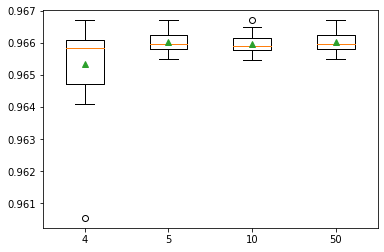

13.647271248183339 minutes


In [ ]:
# explore xgboost random forest number of trees effect on performance
#-- in the beginning of time, we invoke our friendly tools
#-- Source: https://machinelearningmastery.com/random-forest-ensembles-with-xgboost/
#---Imbalanced: https://machinelearningmastery.com/xgboost-for-imbalanced-classification/
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from xgboost import XGBRFClassifier
from matplotlib import pyplot

beginning = default_timer()

# get a list of models to evaluate
def get_models():
	models = dict()
	# define the number of trees to consider
	
	#Subsample ratio of the training instances. Setting it to 0.5 means that XGBoost would randomly sample half of the training data prior to growing trees.
	#colsample_bynode is the subsample ratio of columns for each node (split). Subsampling occurs once every time a new split is evaluated. Columns are subsampled from the set of columns chosen for the current level.
	#Control the balance of positive and negative weights, useful for unbalanced classes. A typical value to consider: sum(negative instances) / sum(positive instances)
	
	n_trees = [4,5,10,50]
	for v in n_trees:
		models[str(v)] = XGBRFClassifier(n_estimators=v, subsample=0.7, colsample_bynode=0.2, scale_pos_weight=scale_weight)
	return models
 
# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
	# define the model evaluation procedure
	cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=7)
	# evaluate the model
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores
 
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	# evaluate the model and collect the results
	scores = evaluate_model(model, X, y)
	# store the results
	results.append(scores)
	names.append(name)
	# summarize performance along the way
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

ending = default_timer()
print((ending - beginning)/60,"minutes")

Como lo vimos anteriormente, a XGBoost le viene valiendo 1000 toneladas de #"%!#
si los datos son balanceados o no, esta cosa hace buen hyperparameter tunning
Aquí algo de teoría: https://machinelearningmastery.com/xgboost-for-imbalanced-classification/

In [ ]:
#--Preparamos una tablita explicativa de la realidad que ayuda a justificar nuestro proyecto
#--No todo el problema es que el vuelo salió con retraso, hay algunos que logran corregir y otros que salen bien pero llegan tarde
def my_agg(x):
    namez = {
        'DELAYED_DEPARTURE': x[x['departure_delay']>=15]['departure_delay'].count(),
        'ONTIME_DEPARTURE': x[x['departure_delay']<15]['departure_delay'].count()}
    return pd.Series(namez)


tabla_proporciones = proporciones.groupby('FLIGHTSTATS').apply(my_agg)
total_datos = len(proporciones.index)
tabla_proporciones = round((tabla_proporciones / total_datos) * 100,1)


In [ ]:
#-- Vemos la tabla de proporciones
#-- Observamos que si el avión sale con retraso solo un 2% del total de vuelos iniciados con retraso logra corregir
#-- Por otra parte, vemos que un 4% de los vuelos que salen en tiempo llegan con retraso (otras condiciones afectan también)
#-- En la tabla abajo, se muestran los % totales de la muestra de ~808 mil vuelos en una matriz por vuelos con retraso de salida y llegada
#-- Los datos son un muestreo de el dataset desbalanceado (lo más real posible)
tabla_proporciones

,DELAYED_DEPARTURE,ONTIME_DEPARTURE
FLIGHTSTATS,,
DELAYED,13.2,3.7
ON TIME,1.8,81.3




Accuracy: 96.64%




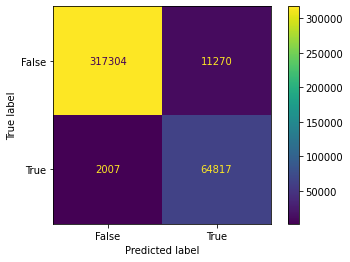

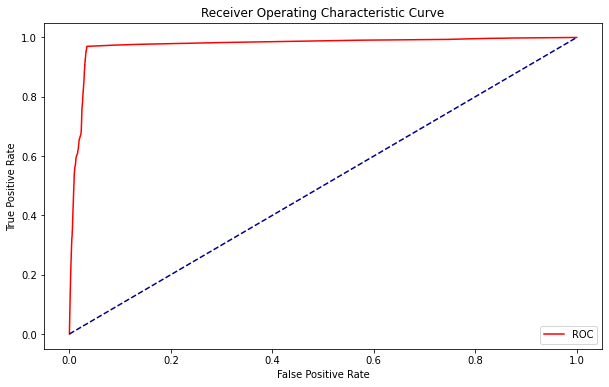

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import roc_curve

modelo = models['50']

modelo.fit(X_train, y_train)

# make predictions for test data
yp_pred = modelo.predict(X_test)
predictions = [round(value) for value in yp_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("\r\n")
print("Accuracy: %.2f%%" % (accuracy * 100.0))

#--Once metrics is imported we can use the confusion matrix function on our actual and predicted values.
confusion_matrix = metrics.confusion_matrix(y_test, predictions)

#--To create a more interpretable visual display we need to convert the table into a confusion matrix display.
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
print("\r\n")
plt.show()

#predict probabilities
probs = modelo.predict_proba(X_test)
 
#Keeping only positive class
probs = probs[:, 1]
 
#Calculating the FPR and TPR
fpr, tpr, thresholds = roc_curve(y_test, probs)
 
#Plotting the figure
plt.figure(figsize = (10,6))
plt.plot(fpr, tpr, color='red', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend()
print("\r\n")
plt.show()

In [ ]:
print(metrics.classification_report(y_test,predictions,digits=2))

              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98    328574
         1.0       0.85      0.97      0.91     66824

    accuracy                           0.97    395398
   macro avg       0.92      0.97      0.94    395398
weighted avg       0.97      0.97      0.97    395398



# 85% de Precisión en Detectar que llegará DEMORADO 🛬

Precision Score = TP / (FP + TP)

From the above formula, you could notice that the value of false-positive would impact the precision score.

Recall Score = TP / (FN + TP)

From the above formula, you could notice that the value of false-negative would impact the recall score.

F1 Score = 2* Precision Score * Recall Score/ (Precision Score + Recall Score/)

# Feature Importance ☝

In [ ]:
#--Lets import libraries, pipeline and labelencoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction import DictVectorizer
import xgboost as xgb
from sklearn.ensemble import ExtraTreesClassifier

In [ ]:
#-- Lets read the CSV we created before
df = pd.read_csv('data.csv',index_col=0)
df["EXPECTED_WEEK_ARRIVAL"]=df["EXPECTED_WEEK_ARRIVAL"].astype(str) #-- change number to category
df['TARGET'] = df.loc[:, 'FLIGHTSTATS'] #Put target to the end of DF
df.pop('FLIGHTSTATS') #Get rid of previous target column
df.head() #show the show

,airline_icao,linetype_code,origin_icao,origin_country,expected_depart_hour,expected_duration,departure_delay,depart_temperature,depart_dew_point,depart_humidity,...,arrival_temperature,arrival_dew_point,arrival_humidity,arrival_pressure,arrival_wind_speed,ds_arrival_wind_speed,ds_arrival_wind_direction,ds_arrival_day_period,EXPECTED_WEEK_ARRIVAL,TARGET
97401,RSL,E,SBRJ,BRAZIL,16.0,45.0,0.0,31.002480,22.001760,58.78,...,28.00224,20.00160,61.81,1015.0,6.0,Light Breeze,NW,Early Evening,5,ON TIME
83684,VRG,N,SBSV,BRAZIL,12.0,146.0,13.0,30.202416,24.101928,69.88,...,22.00000,22.00000,70.00,1015.0,6.0,Light Breeze,Not Informed,Afternoon,11,DELAYED
107419,ITB,R,SBGR,BRAZIL,22.0,71.0,0.0,24.000000,22.000000,70.00,...,22.00000,22.00000,70.00,1015.0,6.0,Light Breeze,Not Informed,Night,4,ON TIME
88961,RSL,R,SBCT,BRAZIL,7.0,41.0,0.0,20.001600,20.001600,100.00,...,22.00176,22.00176,100.00,1015.0,0.0,Not Informed,Not Informed,Early Morning,5,ON TIME
20977,UAL,I,KMIA,UNITED STATES,1.0,493.0,0.0,24.000000,22.000000,70.00,...,22.00000,22.00000,70.00,1015.0,6.0,Light Breeze,Not Informed,Mid Morning,11,ON TIME


In [ ]:
# Create a boolean mask for categorical columns
categorical_mask = (df.dtypes == 'object')
# Get list of categorical columns names
categorical_columns = df.columns[categorical_mask].tolist()
# Create LabelEncoder object: le
le = LabelEncoder()
# Apply LabelEncode to categorical columns
df[categorical_columns] = df[categorical_columns].apply(lambda x: le.fit_transform(x))

Next, is a 10 to 15 minute run

In [ ]:
#-- Simply split the dataframe into X & y
X, y = df.iloc[:,:-1],df.iloc[:,-1]
model = ExtraTreesClassifier()
model.fit(X,y)

ExtraTreesClassifier()

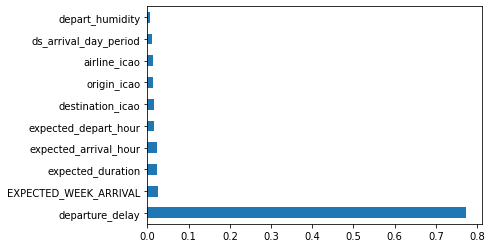

0.009823074749995915 minutes


In [ ]:
#plot graph of feature importances for better visualization
beginning = default_timer()
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()
ending = default_timer()
print((ending - beginning)/60,"minutes")

Top 10 Important Features, that makes sense.
Departure delay is an announced future by the Oracle
Expected week arrival gathers information on the season
airline_icao, origin_icao and destination_icao sounds fair

In [ ]:
df = df.drop(['linetype_code',
       'origin_country',
       'expected_depart_hour',
       'expected_duration',
       'depart_temperature',
       'depart_dew_point',
       'depart_humidity',
       'depart_pressure',
       'depart_wind_speed',
       'ds_depart_wind_speed',
       'ds_depart_wind_direction',
       'ds_depart_day_period',
       'destination_country',
       'expected_arrival_hour',
       'arrival_temperature',
       'arrival_dew_point',
       'arrival_humidity',
       'arrival_pressure',
       'arrival_wind_speed',
       'ds_arrival_wind_speed',
       'ds_arrival_wind_direction',
       'ds_arrival_day_period'], axis=1
       )

In [ ]:
#-- The columns we will work with
df.dtypes

airline_icao               int64
origin_icao                int64
departure_delay          float64
destination_icao           int64
EXPECTED_WEEK_ARRIVAL      int64
TARGET                     int64
dtype: object

# Pipeline for Transformations 🖇

Aaright! we are ready for some pipelines

In [ ]:
# Garbage Collector - use it like gc.collect()
import gc
gc.collect()

10421

In [ ]:
#-- Lets read the CSV we created before
df = pd.read_csv('data.csv',index_col=0)
df["EXPECTED_WEEK_ARRIVAL"]=df["EXPECTED_WEEK_ARRIVAL"].astype(str) #-- change number to category
df['TARGET'] = df.loc[:, 'FLIGHTSTATS'] #Put target to the end of DF
df.pop('FLIGHTSTATS') #Get rid of previous target column

97401     ON TIME
83684     DELAYED
107419    ON TIME
88961     ON TIME
20977     ON TIME
           ...   
28122     ON TIME
47534     ON TIME
71405     ON TIME
16451     ON TIME
44195     DELAYED
Name: FLIGHTSTATS, Length: 1198173, dtype: object

In [ ]:
df = df.drop(['linetype_code',
       'origin_country',
       'expected_depart_hour',
       'expected_duration',
       'depart_temperature',
       'depart_dew_point',
       'depart_humidity',
       'depart_pressure',
       'depart_wind_speed',
       'ds_depart_wind_speed',
       'ds_depart_wind_direction',
       'ds_depart_day_period',
       'destination_country',
       'expected_arrival_hour',
       'arrival_temperature',
       'arrival_dew_point',
       'arrival_humidity',
       'arrival_pressure',
       'arrival_wind_speed',
       'ds_arrival_wind_speed',
       'ds_arrival_wind_direction',
       'ds_arrival_day_period'], axis=1
       )
#-- Simply split the dataframe into X & y
X, y = df.iloc[:,:-1],df.iloc[:,-1]

In [ ]:
from sklearn.preprocessing import LabelEncoder
# Create LabelEncoder object: le
le = LabelEncoder()
# Apply LabelEncode to categorical columns
y = le.fit_transform(y)
y = 1-y

Our Pipeline begins here my friends

In [ ]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline
#We do some categorical and numerical transformations to Help God in his duty
categorical_pipeline = Pipeline(
    steps=[("o-encode", OrdinalEncoder())]
    )

from sklearn.preprocessing import StandardScaler
numeric_pipeline = Pipeline(
    steps=[("scale", StandardScaler())]
)

In [ ]:
#Get a list of categories and numbers in our dataframe
cat_cols = X.select_dtypes(exclude="number").columns
num_cols = X.select_dtypes(include="number").columns

Full Processor PipeLine

In [ ]:
from sklearn.compose import ColumnTransformer

full_processor = ColumnTransformer(
    transformers=[
        ("numeric", numeric_pipeline, num_cols),
        ("categorical", categorical_pipeline, cat_cols),
    ]
)

XGBoost Classifier

In [ ]:
import xgboost as xgb
xgb_cl = xgb.XGBClassifier()
print(type(xgb_cl))

<class 'xgboost.sklearn.XGBClassifier'>


Apply the Pipeline
Split Test and Stratify Outputs

In [ ]:
# Apply preprocessing
X_processed = full_processor.fit_transform(X)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, stratify=y, random_state=1121218
)

In [ ]:
from sklearn.metrics import accuracy_score

# Init classifier
xgb_cl = xgb.XGBClassifier()

# Fit
xgb_cl.fit(X_train, y_train)

# Predict
preds = xgb_cl.predict(X_test)

In [ ]:
# Score
accuracy_score(y_test, preds)

0.9665858772000107

Chose some parameters to play with

Depth - Depth of the trees / control over-fitting

Learning rate - We think is cost function related

scale pos weight - count 0 / count 1 in target

subsample = training 70% then testing 30%, example.

colsample by tree = features to consider by tree

In [ ]:
param_grid = {
    "max_depth": [3, 5, 7],
    "learning_rate": [0.1],
    "scale_pos_weight": [3,4],
    "subsample": [0.7],
    "colsample_bytree": [0.5,0.3],
}

Next will be a 22 minute run

In [ ]:
from sklearn.model_selection import GridSearchCV

# Init classifier
xgb_cl = xgb.XGBClassifier(objective="binary:logistic")

# Init Grid Search
grid_cv = GridSearchCV(xgb_cl, param_grid, n_jobs=-1, cv=3, scoring="roc_auc")

beginning = default_timer()
# Fit
gfit = grid_cv.fit(X_processed, y)
ending = default_timer()
print((ending - beginning)/60,"minutes")

22.86121022831667 minutes


In [ ]:
grid_cv.best_score_

0.9776515282207895

In [ ]:
grid_cv.best_params_

{'colsample_bytree': 0.5,
 'learning_rate': 0.1,
 'max_depth': 5,
 'scale_pos_weight': 4,
 'subsample': 0.7}



Accuracy: 96.62%




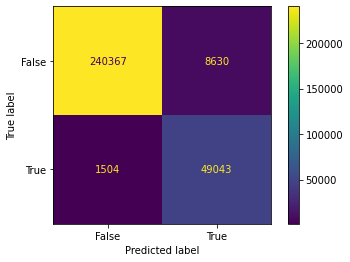

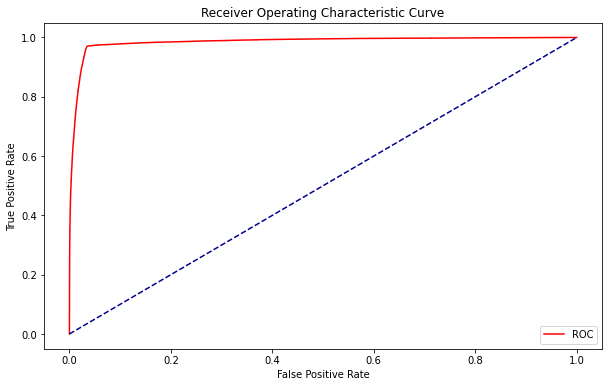

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import roc_curve

modelo = grid_cv.best_estimator_

modelo.fit(X_train, y_train)

# make predictions for test data
yp_pred = modelo.predict(X_test)
predictions = [round(value) for value in yp_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("\r\n")
print("Accuracy: %.2f%%" % (accuracy * 100.0))

#--Once metrics is imported we can use the confusion matrix function on our actual and predicted values.
confusion_matrix = metrics.confusion_matrix(y_test, predictions)

#--To create a more interpretable visual display we need to convert the table into a confusion matrix display.
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
print("\r\n")
plt.show()

#predict probabilities
probs = modelo.predict_proba(X_test)
 
#Keeping only positive class
probs = probs[:, 1]
 
#Calculating the FPR and TPR
fpr, tpr, thresholds = roc_curve(y_test, probs)
 
#Plotting the figure
plt.figure(figsize = (10,6))
plt.plot(fpr, tpr, color='red', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend()
print("\r\n")
plt.show()

In [ ]:
print(metrics.classification_report(y_test,predictions,digits=2))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98    248997
           1       0.85      0.97      0.91     50547

    accuracy                           0.97    299544
   macro avg       0.92      0.97      0.94    299544
weighted avg       0.97      0.97      0.97    299544

